# Tools

In [64]:
import pandas as pd

In [65]:
from IPython.display import display

In [66]:
import matplotlib.pyplot as plt

In [67]:
import numpy as np

In [68]:
from matplotlib import cm

In [69]:
from itertools import combinations

In [70]:
from matplotlib import colormaps

In [71]:
import networkx as nx

In [72]:
import matplotlib.pyplot as plt

In [73]:
import plotly.graph_objects as go

In [74]:
import seaborn as sns

# Main codes

### 0 Data preparation

#### 0.1 Import files

In [75]:
df = pd.read_excel("MRVdata_1709.xlsx")
pd.options.display.max_columns = None
#display(df)
#code above: shows excel table

In [76]:
# read excel file with continent data 
continent_data = pd.read_excel('continents.xlsx')

#### 0.2 Exclusion of data

In [77]:
# filter data frame to exclude studies from 2024
df_filtered = df[df['Year'] != 2024]

In [78]:
df_included = df_filtered[df_filtered['Inclusion/exclusion'] == 'Inclusion'] # new dataframe defined to exclude studies without access or excluded papers
#controll new data frame
#df_included['Inclusion/exclusion'].value_counts()

#### 0.3 Change study location to continent

In [79]:
# create a dictionary for the assignment of countries to continents
country_to_continent = dict(zip(continent_data['Country'], continent_data['Continent']))

# Function to determine the continent based on the country
def get_continent(study_location, continent_column): #part of the function, not column names of the df; will be defined later when function is applied
    if pd.isna(study_location):
        return "Unknown"
    if study_location == "Multiple countries":
        return continent_column  # uses the manually definied continents for the category "Multiple countries"
    return country_to_continent.get(study_location.strip(), "Not specified")  # Search for the country in the dictionary and return the continent or 'not specified'

# avoid warning
df_included = df_included.copy()

# apply function to df_included
df_included['Study location_continent'] = df_included.apply(
    lambda row: get_continent(row['Study location'], row['Study location: Continent']),
    axis=1
)

#pd.options.display.max_columns = None
#display(df_included)

#### 0.4 Group CDR method and color scheme

In [80]:
#columns with all CDR methods
CDR_columns = ['BECCS', 'General forestry', 'A/R', 'Agroforestry', 'Forest management', 'DACCS', 'EW', 'OAE', 'OIF/AU', 'Biochar', 'SCS', 'Blue carbon', 'Restoration of landscapes and peats', 'CCUS', 'Other', 'General CDR', 'DOC', 'Algae ', 'CCS']

In [81]:
# Define the custom color scheme for each CDR method
custom_colors_CDR_method = {
    'BECCS': '#f4d6ae', 'General forestry': '#bcbd22', 'A/R': '#aab792', 
    'Agroforestry': '#e9ede2', 'Forest management': '#d2bfac', 'DACCS': '#dd7500',
    'EW': '#d6b8c1', 'OAE': '#ecf1f9', 'OIF/AU': '#709fca', 'Biochar': '#b7768bff',
    'SCS': '#769112', 'Blue carbon': '#d8e3f1', 'Restoration of landscapes and peats': '#d3dbc7',
    'CCUS': '#e377c2', 'Other': '#e5e5e5', 'General CDR': '#e5b138', 'DOC': '#17becf',
    'Algae ': '#2ca02c', 'CCS': '#d62728'
}

#### 0.5 Group MRV topics and color scheme

In [82]:
#columns with all MRV topics
MRV_columns = ['General MRV', 'Quantification', 'Monitoring', 'Quality', 'Governance', 'Reporting', 'Verification', 'External impacts']

In [83]:
# Define the new custom color scheme for MRV topics
mrv_topic_colors = {
    'General MRV': '#e5b138',      # muted yellow
    'Quantification': '#7da7b8',   # darker bluish-grey
    'Monitoring': '#8dc39f',        # stronger soft green
    'Quality': '#c76a85',           # berry red
    'Governance': '#b39bc8',        # stronger lavender
    'Reporting': '#e1a6b8',         # stronger soft pink
    'Verification': '#a8a8a8',      # medium grey
    'External impacts': '#d0c97b'   # stronger soft yellow
}

#### 0.6 Dataset explosion

In [84]:
#add new column for CDR method and study focus in the dataset
def extract_CDR_method_focus(row):
    CDR_method = []
    CDR_focus = []
    
    for column in CDR_columns:  # previously defined list with columns that contain CDR methods
        if row[column] > 0:
            CDR_method.append(column)
            CDR_focus.append(row[column])
    
    return pd.Series([CDR_method, CDR_focus])

# new copy of the data set to avoid warning
df_included = df_included.copy()

# add new columns to the data frame
df_included['CDR_method'] = df_included.apply(lambda row: extract_CDR_method_focus(row)[0], axis=1)
df_included['CDR_focus'] = df_included.apply(lambda row: extract_CDR_method_focus(row)[1], axis=1)

#display dataset to see if newly added columns are correct
#pd.options.display.max_columns = None
#display(df_included)

In [85]:
#add new column for MRV topic and study focus to the dataset
def extract_MRV_topic_focus(row):
    MRV_topic = []
    MRV_focus = []
    
    for column in MRV_columns:  # previously defined list with columns that contain MRV topics
        if row[column] > 0:
            MRV_topic.append(column)
            MRV_focus.append(row[column])
    
    return pd.Series([MRV_topic, MRV_focus])

# new copy of the data set to avoid warning
df_included = df_included.copy()

# add new columns to the data frame
df_included['MRV_topic'] = df_included.apply(lambda row: extract_MRV_topic_focus(row)[0], axis=1)
df_included['MRV_focus'] = df_included.apply(lambda row: extract_MRV_topic_focus(row)[1], axis=1)

#display dataset to see if newly added columns are correct
#pd.options.display.max_columns = None
#display(df_included)

In [86]:
# explode CDR method and focus
df_CDRexplode = df_included.explode(['CDR_method', 'CDR_focus'])

# explode MRV topic and focus
df_exploded = df_CDRexplode.explode(['MRV_topic', 'MRV_focus'])

# every CDR method and every MRV topic is in one line (in combination with study focus)

#display dataset to see if newly added columns are correct
#pd.options.display.max_columns = None
#display(df_exploded)

#### 0.7 Definition CDR groups & color scheme

In [ ]:
# Group CDR Methods to marine, terrestrial, and CCS technologies. Keep A/R and SCS as individual technologies
cdr_group_mapping = {
     # Marine CDR group
    "OIF/AU":"Marine CDR",
    "Blue carbon": "Marine CDR",
    "OAE": "Marine CDR",
    "DOC": "Marine CDR",
    "Algae ": "Marine CDR",
    
    # Terrestrial CDR group
    "EW": "Terrestrial CDR",
    "Biochar": "Terrestrial CDR",
    "Restoration of landscapes and peats": "Terrestrial CDR",
    
    # CCS group
    "DACCS": "CCS",
    "BECCS": "CCS",
    "CCUS": "CCS",
    "CCS": "CCS",
    
    # General CDR/Other group
    "General CDR": "General CDR/Other",
    "Other": "General CDR/Other",

    # SCS
    "SCS": "SCS",

    # Forestry
    "General forestry": "Forestry",
    "A/R": "Forestry",
    "Agroforestry": "Forestry",
    "Forest management": "Forestry",
}
# Create a new column ‘CDR_group’ in df_exploded based on the ‘CDR_method’ column
df_exploded['CDR_group'] = df_exploded['CDR_method'].map(cdr_group_mapping)

# Display the updated DataFrame
#pd.options.display.max_columns = None  # Show all columns
#display(df_exploded)

In [ ]:
# Define the custom color scheme for each CDR group
cdr_group_colors = {
    "Marine CDR": '#7eaed3',    # bluew for Marine CDR
    "Terrestrial CDR": '#b2df8a',  # green for Terrestrial CDR
    "CCS": '#ff7f00',            # orange for CCS
    "General CDR/Other": '#e5e5e5', # grey for General/Other
    "SCS": '#C1A28A' ,            # brown for SCS
    "Forestry": '#8fbc8f'         # green for Forestry
}


### Exploded dataset: CDR method & study location

#### Figure: CDR Technologies per Location

C:\Users\chris\AppData\Local\Temp\ipykernel_26636\2753437128.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  continent_method_counts = df_exploded.groupby(['Study location_continent', 'CDR_method']).size().reset_index(name='Count')


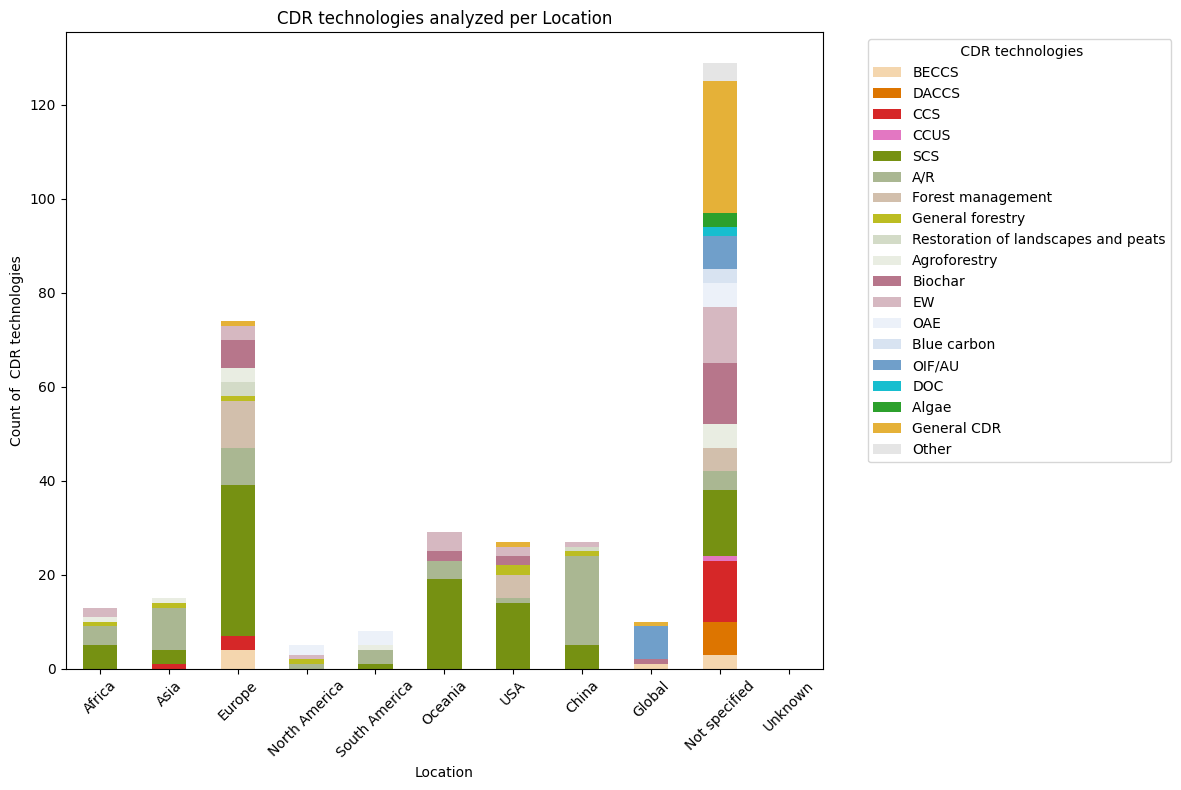

In [96]:
# Set the order of continents to be shown on the x-axis
desired_order_cont = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania', 'USA', 'China', 'Global',
                      'Not specified', 'Unknown']  

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['Study location_continent'] = pd.Categorical(
    df_exploded['Study location_continent'],
    categories=desired_order_cont,
    ordered=True
)

# Set the order of CDR technologies to be shown in the bars
desired_order_CDR = ['BECCS', 'DACCS', 'CCS', 'CCUS','SCS', 'A/R', 'Forest management', 'General forestry', 
                     'Restoration of landscapes and peats', 'Agroforestry', 'Biochar', 'EW', 'OAE', 'Blue carbon', 'OIF/AU',
                     'DOC', 'Algae ', 'General CDR', 'Other']

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['CDR_method'] = pd.Categorical(
    df_exploded['CDR_method'],
    categories=desired_order_CDR,
    ordered=True
)

# Group by continent and CDR method, and count occurrences
continent_method_counts = df_exploded.groupby(['Study location_continent', 'CDR_method']).size().reset_index(name='Count')

# Pivot the data for the stacked bar plot
pivot_data = continent_method_counts.pivot(index='Study location_continent', columns='CDR_method', values='Count').fillna(0)

# Create a stacked bar plot
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=custom_colors_CDR_method)

plt.title("CDR technologies analyzed per Location")
plt.xlabel("Location")
plt.ylabel("Count of  CDR technologies")
plt.xticks(rotation=45)
plt.legend(title=" CDR technologies", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Figure: CDR groups per Location

C:\Users\chris\AppData\Local\Temp\ipykernel_26636\1731976236.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  continent_method_counts = df_exploded.groupby(['Study location_continent', 'CDR_group']).size().reset_index(name='Count')


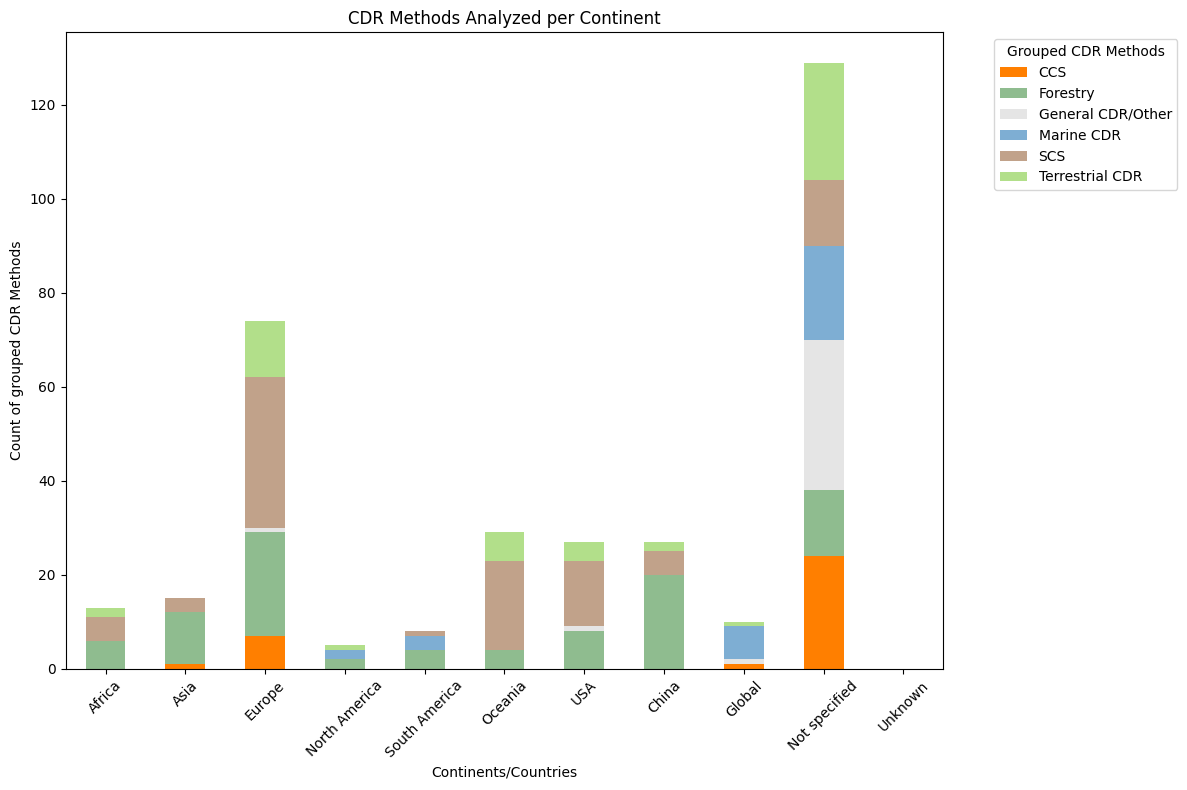

In [97]:
# Set the order of continents to be shown on the x-axis
desired_order = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania', 'USA', 'China', 'Global', 'Not specified', 'Unknown']  

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['Study location_continent'] = pd.Categorical(
    df_exploded['Study location_continent'],
    categories=desired_order,
    ordered=True
)

# Group by continent and CDR method, and count occurrences
continent_method_counts = df_exploded.groupby(['Study location_continent', 'CDR_group']).size().reset_index(name='Count')

# Pivot the data for the stacked bar plot
pivot_data = continent_method_counts.pivot(index='Study location_continent', columns='CDR_group', values='Count').fillna(0)

# Create a stacked bar plot
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=cdr_group_colors)
plt.title("CDR Methods Analyzed per Continent")
plt.xlabel("Continents/Countries")
plt.ylabel("Count of grouped CDR Methods")
plt.xticks(rotation=45)
plt.legend(title="Grouped CDR Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [98]:
# too chaotic when taking individual CDR methods into account 
# should we merge not specified and unknown? --> I'll change that later. That was a control for missing data

### Exploded dataset: Which CDR methods are analyzed together?

#### Data preparation

In [99]:
# Group by 'Publication ID' and aggregate the unique CDR methods per publication
grouped = df_exploded.groupby('Publication ID')['CDR_method'].unique()

# Create pairs of CDR methods for each publication, including both directions
pairs = []

for methods in grouped:
    # Create all possible combinations of CDR methods within each publication
    for combo in combinations(methods, 2):
        # Add both directions of the pair
        pairs.append(combo)  # Method 1 -> Method 2
        pairs.append(combo[::-1])  # Method 2 -> Method 1 (reverse)

# Create a DataFrame of pairs and count the occurrences
pair_counts_CDR = pd.DataFrame(pairs, columns=['Method 1', 'Method 2']).value_counts().reset_index(name='Count')

# Display the results
# print(pair_counts_CDR)

In [100]:
# Group by 'Publication ID' and aggregate the unique CDR groups per publication
grouped = df_exploded.groupby('Publication ID')['CDR_group'].unique()

# Create pairs of CDR groups for each publication, including both directions
pairs = []

for methods in grouped:
    # Create all possible combinations of CDR groups within each publication
    for combo in combinations(methods, 2):
        # Add both directions of the pair
        pairs.append(combo)  # Method 1 -> Method 2
        pairs.append(combo[::-1])  # Method 2 -> Method 1 (reverse)

# Create a DataFrame of pairs and count the occurrences
pair_counts_CDR_group = pd.DataFrame(pairs, columns=['Method 1', 'Method 2']).value_counts().reset_index(name='Count')

# Display the results
#print(pair_counts_CDR_group)

#### Network Graph

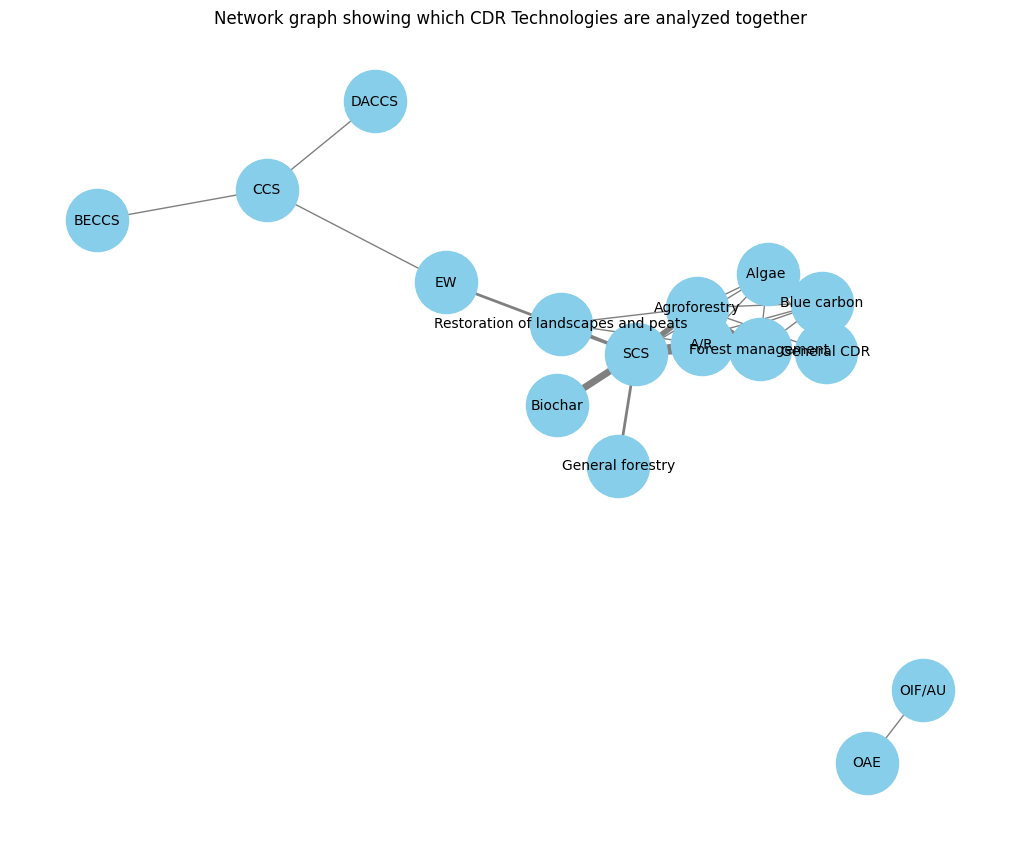

In [101]:
# Create a graph from the pair counts
G = nx.Graph()

# Add edges to the graph, with the weight being the count of co-occurrence
for _, row in pair_counts_CDR.iterrows():
    G.add_edge(row['Method 1'], row['Method 2'], weight=row['Count'])

# Extract node colors based on the color mapping
#node_colors = [tc.get(node, default_color) for node in G.nodes] --> edit color scheme

# Plot the network graph
plt.figure(figsize=(10, 8))

# Use edge weights to adjust the width of the edges
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

# Draw the graph with nodes, edges, and labels
pos = nx.spring_layout(G, k=0.5, seed=42)  # Positioning the nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, edge_color='gray', width=weights)

plt.title("Network graph showing which CDR Technologies are analyzed together")
plt.show()

In [102]:
# --> edit color scheme

#### Heatmap

##### CDR methods

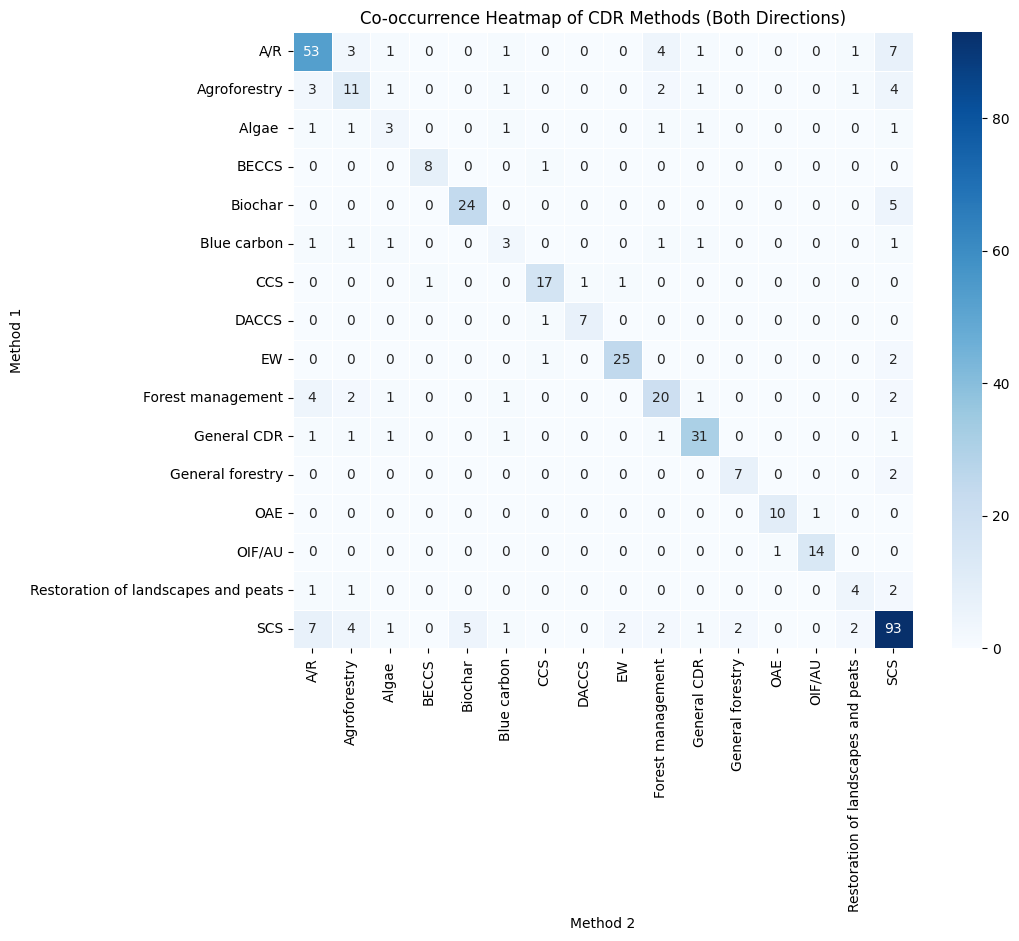

In [103]:
# Calculate the count of individual CDR methods analyzed
individual_counts = df_exploded['CDR_method'].value_counts()

# Create a DataFrame for individual counts
individual_counts_df = pd.DataFrame(individual_counts).reset_index()
individual_counts_df.columns = ['CDR_method', 'Count']

# Create a pivot table for pair counts
heatmap_data = pair_counts_CDR.pivot(index='Method 1', columns='Method 2', values='Count').fillna(0)

# Add individual counts to the diagonal
for method in heatmap_data.index:
    if method in individual_counts_df['CDR_method'].values:
        heatmap_data.loc[method, method] = individual_counts_df.loc[individual_counts_df['CDR_method'] == method, 'Count'].values[0]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", linewidths=.5)

plt.title("Co-occurrence Heatmap of CDR Methods (Both Directions)")
plt.show()

##### CDR groups

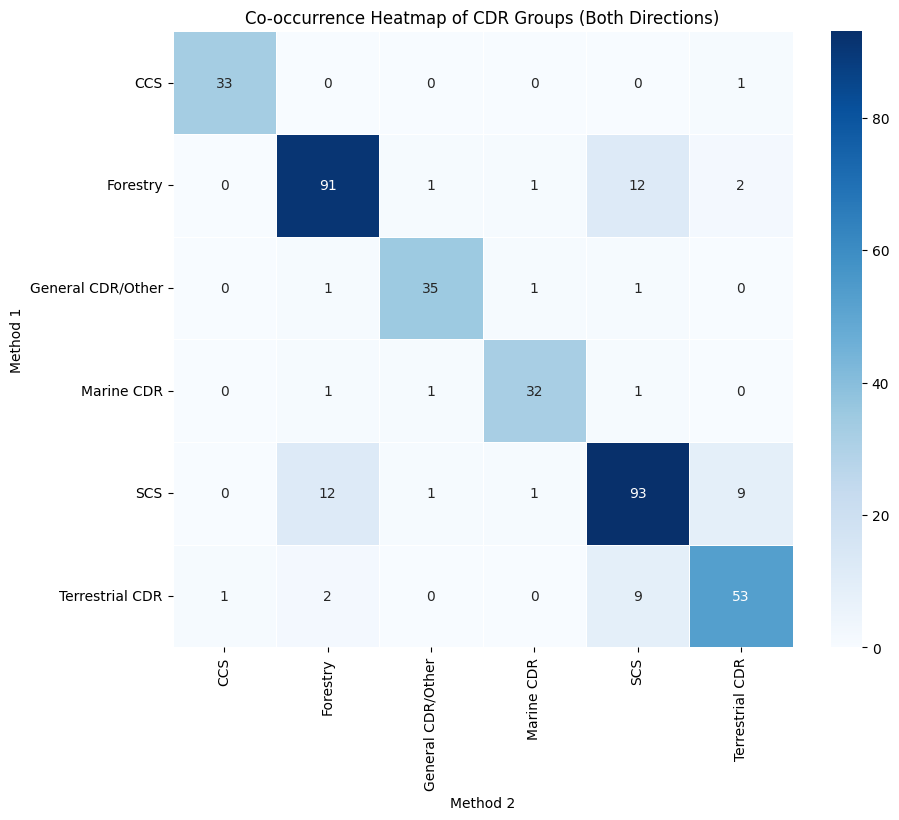

In [104]:
# Calculate the count of individual CDR groups analyzed
individual_counts_group = df_exploded['CDR_group'].value_counts()

# Create a DataFrame for individual counts
individual_counts_group_df = pd.DataFrame(individual_counts_group).reset_index()
individual_counts_group_df.columns = ['CDR_group', 'Count']

# Create a pivot table for pair counts
heatmap_data_group = pair_counts_CDR_group.pivot(index='Method 1', columns='Method 2', values='Count').fillna(0)

# Add individual counts to the diagonal
for method in heatmap_data_group.index:
    if method in individual_counts_group_df['CDR_group'].values:
        heatmap_data_group.loc[method, method] = individual_counts_group_df.loc[individual_counts_group_df['CDR_group'] == method, 'Count'].values[0]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_group, annot=True, cmap="Blues", linewidths=.5)

plt.title("Co-occurrence Heatmap of CDR Groups (Both Directions)")
plt.show()

#### Heatmap including focus level

In [105]:
# Convert the CDR_focus column to integers, converting non-numeric values to NaN
df_exploded['CDR_focus'] = pd.to_numeric(df_exploded['CDR_focus'], errors='coerce').astype('Int64')

C:\Users\chris\AppData\Local\Temp\ipykernel_26636\3318310989.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = deduped_df.pivot_table(index='CDR_method_main', columns='CDR_method_side', aggfunc='size', fill_value=0)


Pivot table with unique publications counted:
 CDR_method_side                      BECCS  DACCS  CCS  CCUS  SCS  A/R  \
CDR_method_main                                                          
BECCS                                    0      0    0     0    0    0   
DACCS                                    0      0    0     0    0    0   
CCS                                      0      0    0     0    0    0   
CCUS                                     0      0    0     0    0    0   
SCS                                      0      0    0     0    0    1   
A/R                                      0      0    0     0    0    0   
Forest management                        0      0    0     0    0    0   
General forestry                         0      0    0     0    0    0   
Restoration of landscapes and peats      0      0    0     0    0    0   
Agroforestry                             0      0    0     0    1    1   
Biochar                                  0      0    0     0    3

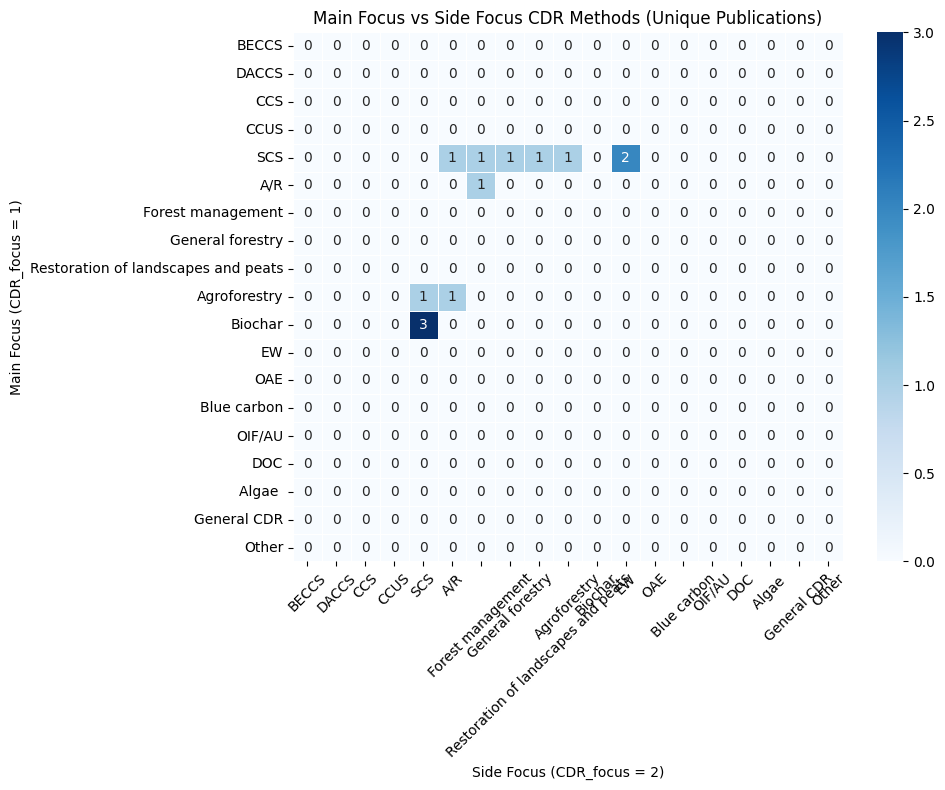

In [106]:
# Create separate DataFrames for main focus (CDR_focus = 1) and side focus (CDR_focus = 2)
main_focus_df = df_exploded[df_exploded['CDR_focus'] == 1][['Publication ID', 'CDR_method']].rename(columns={'CDR_method': 'CDR_method_main'})
side_focus_df = df_exploded[df_exploded['CDR_focus'] == 2][['Publication ID', 'CDR_method']].rename(columns={'CDR_method': 'CDR_method_side'})

# Merge the main and side focus DataFrames on 'Publication ID'
# This merge keeps only publications that have both a main focus and a side focus
merged_df = pd.merge(main_focus_df, side_focus_df, on='Publication ID')

# Remove duplicates to ensure each publication is only counted once
# Drop duplicate rows based on Publication ID and the CDR_method_main/CDR_method_side combination
deduped_df = merged_df.drop_duplicates(subset=['Publication ID', 'CDR_method_main', 'CDR_method_side'])

# Create the pivot table to show relationships between main and side focuses
# Index represents CDR_method_main (y-axis), columns represent CDR_method_side (x-axis)
pivot_table = deduped_df.pivot_table(index='CDR_method_main', columns='CDR_method_side', aggfunc='size', fill_value=0)

# Display the pivot table
print("Pivot table with unique publications counted:\n", pivot_table)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="Blues", linewidths=.5)
plt.title("Main Focus vs Side Focus CDR Methods (Unique Publications)")
plt.xlabel("Side Focus (CDR_focus = 2)")
plt.ylabel("Main Focus (CDR_focus = 1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
